## 1. Feature Extraction & Feature Selection


Functions for feature extraction

In [2]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.feature import hog, local_binary_pattern

# read in data from train folder
metadata = pd.read_csv("train/train_metadata.csv")
metadata['image_path'] = 'train/' + metadata['image_path'].astype(str)

# for image resize
IMAGE_SIZE = (64, 64)

# constants for LBP extraction
LBP_RADIUS = 1
LBP_POINTS = 8 * LBP_RADIUS

show_prep = 0

def preprocess_image(path, blur_kernel=(3, 3)):
    """
    preprocess image with resizing and noise reduction
    """
    image = cv2.imread(path)
    image = cv2.resize(image, IMAGE_SIZE)
    image = cv2.GaussianBlur(image, blur_kernel, 0)
    
    if show_prep:
        # show noise reduced image if requested
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image_rgb)
        plt.title("Noise Reduced Image")
        plt.axis("off")
        plt.show()

    return image

def extract_contour_features(image):
    """
    Extract features based on contour for traffic sign including:
    number of vertices, circularity ratio
    """
    # apply grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # apply Canny Edge Detection algorithm
    edges = cv2.Canny(gray, 50, 150)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # apply adaptive thresholding to lower the requirement for contour if no contour found
    if not contours:
        thresh = cv2.adaptiveThreshold(
            gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY_INV, 11, 2
        )
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour = max(contours, key=cv2.contourArea)
    
    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)

    # circularity ratio
    circularity = (4 * np.pi * area / (perimeter ** 2)) if perimeter != 0 else 0

    # number of vertices
    approx = cv2.approxPolyDP(contour, 0.02 * perimeter, True)
    num_vertices = len(approx)

    return np.array([num_vertices, circularity])

def extract_hog(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return hog(gray, orientations=9, pixels_per_cell=(8, 8),
               cells_per_block=(2, 2), block_norm='L2-Hys', feature_vector=True)

def extract_color_histogram(image):
    chans = cv2.split(image)
    hist = [cv2.calcHist([c], [0], None, [32], [0, 256]).flatten() for c in chans]
    return np.concatenate(hist)

def extract_hsv_histogram(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h_hist = cv2.calcHist([hsv], [0], None, [30], [0, 180])
    s_hist = cv2.calcHist([hsv], [1], None, [32], [0, 256])
    v_hist = cv2.calcHist([hsv], [2], None, [32], [0, 256])
    return np.concatenate([h_hist.flatten(), s_hist.flatten(), v_hist.flatten()])

def extract_lbp(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    lbp = local_binary_pattern(gray, P=LBP_POINTS, R=LBP_RADIUS, method="uniform")
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, LBP_POINTS + 3), range=(0, LBP_POINTS + 2))
    return hist.astype("float")

def extract_features_df(df):
    """
    extract image features based on a given dataframe of image path
    """
    column_names = []
    feature_frames = []

    for p in df['image_path']:
        # extract feature for each image
        if not column_names:
            features, column_names = extract_all_features(p, get_column_names=True)
        else:
            features = extract_all_features(p)

        feature_frames.append(features)
    
    # convert to dataframe
    feature_df = pd.DataFrame(feature_frames, columns=column_names)
    return feature_df

def extract_all_features(image_path, get_column_names=False):
    """
    Extract all the features with a given image path
    """
    # apply preprocessing
    image = preprocess_image(image_path)

    # extract the features
    contour = extract_contour_features(image)
    hog = extract_hog(image)
    ch = extract_color_histogram(image)
    hsv = extract_hsv_histogram(image)
    lbp = extract_lbp(image)

    # combine all the features
    features = np.concatenate([contour, hog, ch, hsv, lbp])
    
    global show_prep
    if show_prep > 0:
        show_prep -= 1

    if get_column_names:
        # generate column names for dataframe
        column_names = []
        column_names.extend(['contour_vertices', 'contour_circularity'])
        column_names.extend([f'hog_{i}' for i in range(len(hog))])
        column_names.extend([f'ch_{i}' for i in range(len(ch))])
        column_names.extend([f'hsv_{i}' for i in range(len(hsv))])
        column_names.extend([f'lbp_{i}' for i in range(len(lbp))])
        return features, column_names

    return features


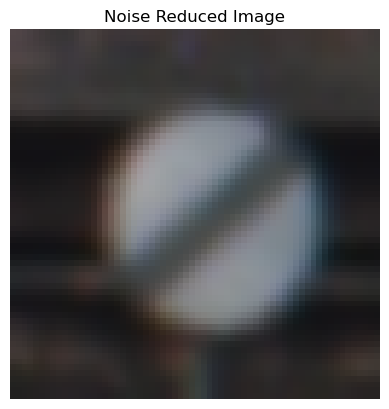

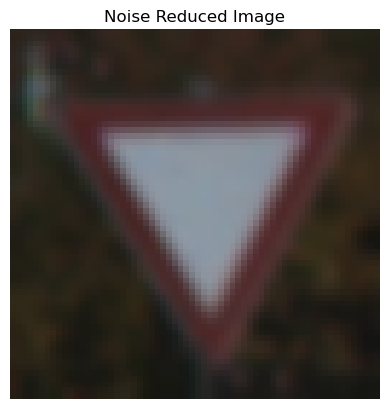

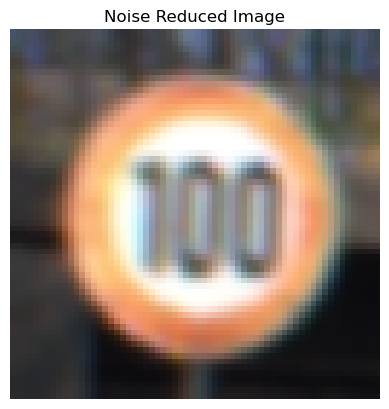

Dimensionality for the features: 1966


In [2]:
show_prep = 3

X = extract_features_df(metadata)

# provide descriptive statistics for each feature
summary = pd.DataFrame({
    'mean': round(X.mean(), 2),
    'median': round(X.median(), 2)
})
summary.to_csv("descriptive_statistics.csv")
print("Dimensionality for the features:", len(X.columns))


Observations for the dataset

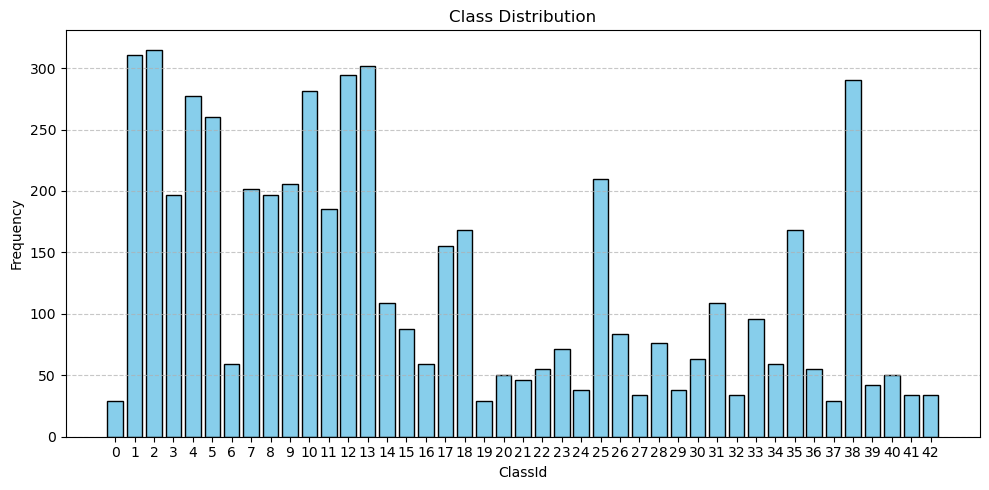

Number of Classes: 43
Number of Instances for Training: 5488
Below 32x32: 687 images
Below 64x64: 4373 images
Below 128x128: 5397 images
Below 256x256: 5488 images


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def plot_class_histogram(class_array, title='Class Distribution', xlabel='ClassId', ylabel='Frequency'):
    """
    plot the class distribution with givne array of classes
    """
    unique, counts = np.unique(class_array, return_counts=True)
    
    plt.figure(figsize=(10, 5))
    plt.bar(unique, counts, color='skyblue', edgecolor='black')
    plt.xticks(unique)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

def image_size_table(df):
    """
    display a table with frequency of images with image size below each threshold
    """
    thresholds = [32, 64, 128, 256]
    counts = {t: 0 for t in thresholds}
    
    for path in df['image_path']:
        # count frequency
        width, height = Image.open(path).size
        for t in thresholds:
            if width < t and height < t:
                counts[t] += 1

    for t in thresholds:
        print(f"Below {t}x{t}: {counts[t]} images")


# display class distribution for the training set
plot_class_histogram(metadata['ClassId'])
print("Number of Classes:", len(np.unique(metadata['ClassId'])))
print("Number of Instances for Training:", len(metadata))
# show info regarding image size
image_size_table(metadata)



## 2. Model Training

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import KBinsDiscretizer
import pandas as pd

# apply 80%-20% train test split
X_train, X_test, y_train, y_test = train_test_split(
        metadata, metadata['ClassId'], test_size=0.2, random_state=123, stratify=metadata['ClassId']
    )

# discretize each feature for calculating mutual information
class QuantileDiscretizer(BaseEstimator, TransformerMixin):
    def __init__(self, n_bins=43):
        self.n_bins = n_bins
        self.discretizer = None

    def fit(self, X, y=None):
        self.discretizer = KBinsDiscretizer(n_bins=self.n_bins, encode='ordinal', strategy='uniform')
        self.discretizer.fit(X)
        return self

    def transform(self, X):
        return self.discretizer.transform(X)


KNN hyperparameter tuning.
Estimated runtime (tested on Windows 10): Approx 5-7 minutes.
This cell can be skipped without causing an error.

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

def knn_tuning(train_df, k_values=[3, 5, 7, 9], voting_strategies=['uniform', 'distance'], top_k_features=50):
    """
    Tune the following hyperparameters for KNN: K and voting strategies.
    """

    # extract features from all images
    print("Extracting features...")
    X = extract_features_df(train_df)
    print("Finished feature extraction.")

    # get ground truth labels
    y = train_df['ClassId'].values
    n_classes = len(np.unique(y))
    
    # cross validation with stratified sampling
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=100)
    results = []

    for k in k_values:
        for voting in voting_strategies:
            # grid search to find the optimal sets of hyperparameters
            # note we use pipeline to ensure each iteration the MI, normalization & PCA were only fit
            # to the selected folds for training
            pipe = Pipeline([
                ('discretizer', QuantileDiscretizer(n_bins=n_classes)),
                ('mi_select', SelectKBest(lambda X, y: mutual_info_classif(X, y, discrete_features=True), k=top_k_features)),
                ('scaler', MinMaxScaler()),
                ('pca', PCA(n_components=0.9, svd_solver='full')),
                ('knn', KNeighborsClassifier(n_neighbors=k, weights=voting, n_jobs=-1))
            ])
            score = cross_val_score(pipe, X, y, cv=cv, scoring='accuracy').mean()
            results.append({'k': k, 'weights': voting, 'score': score})
            print(f"K={k}, Weights={voting} → Accuracy: {score:.4f}")

    # choose the best set of hyperparameters and train a final model
    best = max(results, key=lambda x: x['score'])
    print(f"\nBest Parameters → K={best['k']}, Weights={best['weights']} → Accuracy: {best['score']:.4f}")

    final_pipeline = Pipeline([
        ('discretizer', QuantileDiscretizer(n_bins=n_classes)),
        ('mi_select', SelectKBest(lambda X, y: mutual_info_classif(X, y, discrete_features=True), k=top_k_features)),
        ('scaler', MinMaxScaler()),
        ('pca', PCA(n_components=0.9, svd_solver='full')),
        ('knn', KNeighborsClassifier(n_neighbors=best['k'], weights=best['weights'], n_jobs=-1))
    ])
    final_pipeline.fit(X, y)

    return final_pipeline


knn_model = knn_tuning(X_train)


Extracting features...
Finished feature extraction.
K=3, Weights=uniform → Accuracy: 0.7196
K=3, Weights=distance → Accuracy: 0.7405
K=5, Weights=uniform → Accuracy: 0.7312
K=5, Weights=distance → Accuracy: 0.7469
K=7, Weights=uniform → Accuracy: 0.7248
K=7, Weights=distance → Accuracy: 0.7412
K=9, Weights=uniform → Accuracy: 0.7271
K=9, Weights=distance → Accuracy: 0.7419

Best Parameters → K=5, Weights=distance → Accuracy: 0.7469


Random Forest hyperparameter tuning.
Estimated runtime (tested on Windows 10): Approx 6-8 minutes.
This cell can be skipped without causing an error.

In [6]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from math import log2

def rf_tuning(train_df, n_estimators_list=[50, 100, 200], c_values=[0.5, 1.0, 1.5, 2.0], top_k_features=300):
    """
    Tune the following hyperparameters for Random Forest: number of trees, max features
    """
    
    # extract features from all images
    print("Extracting features...")
    X = extract_features_df(train_df)
    print("Finished feature extraction.")
    
    # get ground truth labels
    y = train_df['ClassId'].values
    n_classes = len(np.unique(y))
    
    # cross validation with stratified sampling
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=100)
    results = []

    for n_trees in n_estimators_list:
        for c in c_values:
            # apply the formula c*(log(F)+1) for max feature
            max_features_val = int(np.clip(c * (log2(top_k_features) + 1), 1, top_k_features))

            # calculate MI only on train folds to prevent leakage
            pipe = Pipeline([
                ('discretizer', QuantileDiscretizer(n_bins=n_classes)),
                ('mi_select', SelectKBest(lambda X, y: mutual_info_classif(X, y, discrete_features=True), k=top_k_features)),
                ('rf', RandomForestClassifier(
                    n_estimators=n_trees,
                    max_features=max_features_val,
                    class_weight='balanced',
                    n_jobs=-1, 
                    random_state=123))
            ])
            score = cross_val_score(pipe, X, y, cv=cv, scoring='accuracy').mean()
            results.append({'n_estimators': n_trees, 'c': c, 'max_features': max_features_val, 'score': score})
            print(f"Trees={n_trees}, c={c:.2f} (max_features={max_features_val}) → Accuracy: {score:.4f}")
    
    best = max(results, key=lambda x: x['score'])
    print(f"\nBest Parameters → Trees={best['n_estimators']}, c={best['c']:.2f}, max_features={best['max_features']} → Accuracy: {best['score']:.4f}")
    
    # choose the best set of hyperparameters and train a final model
    final_pipeline = Pipeline([
        ('discretizer', QuantileDiscretizer(n_bins=n_classes)),
        ('mi_select', SelectKBest(lambda X, y: mutual_info_classif(X, y, discrete_features=True), k=top_k_features)),
        ('rf', RandomForestClassifier(
            n_estimators=best['n_estimators'],
            max_features=best['max_features'],
            class_weight='balanced',
            n_jobs=-1,
            random_state=123))
    ])
    final_pipeline.fit(X, y)

    return final_pipeline


rf_model = rf_tuning(X_train)

Extracting features...
Finished feature extraction.
Trees=50, c=0.50 (max_features=4) → Accuracy: 0.9050
Trees=50, c=1.00 (max_features=9) → Accuracy: 0.9121
Trees=50, c=1.50 (max_features=13) → Accuracy: 0.9153
Trees=50, c=2.00 (max_features=18) → Accuracy: 0.9175
Trees=100, c=0.50 (max_features=4) → Accuracy: 0.9212
Trees=100, c=1.00 (max_features=9) → Accuracy: 0.9228
Trees=100, c=1.50 (max_features=13) → Accuracy: 0.9264
Trees=100, c=2.00 (max_features=18) → Accuracy: 0.9216
Trees=200, c=0.50 (max_features=4) → Accuracy: 0.9271
Trees=200, c=1.00 (max_features=9) → Accuracy: 0.9328
Trees=200, c=1.50 (max_features=13) → Accuracy: 0.9310
Trees=200, c=2.00 (max_features=18) → Accuracy: 0.9244

Best Parameters → Trees=200, c=1.00, max_features=9 → Accuracy: 0.9328


CNN architecture. THIS SECTION MUST BE EXECUTED!

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms
from sklearn.model_selection import train_test_split

MEAN_RGB = []
STD_RGB = []

# for loading image dataset only
class ImageDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image = Image.open(self.df.loc[idx, 'image_path']).convert('RGB')
        return self.transform(image)

def ImageAndLabel(df, transform):
    """
    Load both image dataset and truth labels.
    """
    class _Dataset(Dataset):
        def __init__(self, df, transform):
            self.df = df.reset_index(drop=True)
            self.transform = transform

        def __len__(self):
            return len(self.df)

        def __getitem__(self, idx):
            image = Image.open(self.df.loc[idx, 'image_path']).convert('RGB')
            label = int(self.df.loc[idx, 'ClassId'])
            image = self.transform(image)
            return image, label

    return _Dataset(df, transform)

def compute_mean_std(df, image_size=(32, 32), batch_size=64):
    """
    Compute mean and standard deviation of RGB for training set.
    """
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor()
    ])

    # get image dataset
    dataset = ImageDataset(df, transform)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=0)

    # compute RGB (3 channels) mean and std
    n_channels = 3
    mean = torch.zeros(n_channels)
    std = torch.zeros(n_channels)
    total_images = 0

    # sum up all RGB values and std
    for images in loader:
        batch_size = images.size(0)
        total_images += batch_size
        images = images.view(batch_size, n_channels, -1)
        mean += images.mean(dim=2).sum(dim=0)
        std += images.std(dim=2).sum(dim=0)

    # compute mean value and std, then update the parameter for normalization function
    mean /= total_images
    std /= total_images

    global MEAN_RGB, STD_RGB
    MEAN_RGB, STD_RGB = mean.tolist(), std.tolist()

def build_cnn():
    """
    LeNet-5 architecture adopted from Y. Lecun, L. Bottou, Y. Bengio and P. Haffner, 
    "Gradient-based learning applied to document recognition,"
    in Proceedings of the IEEE, vol. 86, no. 11, pp. 2278-2324, Nov. 1998, doi: 10.1109/5.726791.
    """
    return nn.Sequential(
        nn.Conv2d(3, 6, kernel_size=5),    # modification to include 3 channels for RGB 
        nn.Tanh(),
        nn.AvgPool2d(2, 2),                    

        nn.Conv2d(6, 16, kernel_size=5),
        nn.Tanh(),
        nn.AvgPool2d(2, 2),

        nn.Flatten(),
        nn.Linear(16 * 5 * 5, 120),
        nn.Tanh(),
        nn.Linear(120, 84),
        nn.Tanh(),
        nn.Linear(84, 43)   # modification for 43 class multiclassification
    )

def get_transforms():
    """
    Apply preprocessing to the image including resizing and normalization.
    """
    return transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize(mean=MEAN_RGB,
                             std=STD_RGB)
    ])

def train_one_epoch(model, loader, optimizer, loss_fn, device):
    """
    Train the CNN model for 1 epoch, and return the average cross entropy loss.
    """
    model.train()
    total_loss = 0

    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        # add up cross-entropy loss
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)

def train_cnn_model(df, batch_size=64, lr=0.001, epochs=10):
    """
    Preprocess GTSRB images and train CNN with LeNet-5 architecture
    """
    device = torch.device('cpu')
    model = build_cnn().to(device)

    # first update the mean and std RGB value witht the training set
    compute_mean_std(df)
    print("Mean:", MEAN_RGB, "Std:", STD_RGB)

    # apply resizing and normalization
    transform = get_transforms()
    dataset = ImageAndLabel(df, transform)

    # shuffle is used to randomize batch input into the CNN model
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # use cross-entropy loss function for evaluation
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # train CNN model
    for epoch in range(1, epochs + 1):
        avg_loss = train_one_epoch(model, loader, optimizer, loss_fn, device)
        print(f"Epoch {epoch}: Loss = {avg_loss:.4f}")

    return model

def cnn_predict(model, df, batch_size=64):
    """
    Prediction function for CNN model.
    """
    device = torch.device('cpu')
    model.eval()

    # apply resizing and normalization
    transform = get_transforms()
    dataset = ImageDataset(df, transform)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    predictions = []

    # get all predictions based on argmax of softmax values
    with torch.no_grad():
        for images in loader:
            images = images.to(device)
            outputs = model(images)
            predicted = torch.argmax(outputs, 1)
            predictions.extend(predicted.cpu().numpy())

    return predictions


CNN hyperparameter tuning.
Estimated runtime (tested on Windows 10 without Cuda): Approx 60-90 minutes.
This cell can be skipped without causing an error.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.model_selection import ParameterGrid


def cnn_tune(df, param_grid={'batch_size': [32, 64, 128], 'lr': [1e-2, 1e-3, 1e-4]}, patience=10, max_epochs=200):
    """
    Tune the following hyperparameters for CNN: batch size, learning rate.
    """
    device = torch.device('cpu')
    
    # single holdout with 75%-25% split, so that the validation set has the same size as the test set
    train_df, val_df = train_test_split(df, test_size=0.25, stratify=df['ClassId'], random_state=100)

    # first update the mean and std RGB value witht the training set
    compute_mean_std(train_df)
    print("Mean:", MEAN_RGB, "Std:", STD_RGB)

    # apply resizing and normalization
    transform = get_transforms()
    train_dataset = ImageAndLabel(train_df, transform)
    val_dataset = ImageAndLabel(val_df, transform)

    loss_fn = nn.CrossEntropyLoss()
    best_overall_acc = 0
    best_params = {}

    for params in ParameterGrid(param_grid):
        # apply grid search
        batch_size = params['batch_size']
        lr = params['lr']
        print(f"\n--- Tuning: Batch Size = {batch_size}, LR = {lr} ---")

        # load datasets and construct CNN model
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        model = build_cnn().to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr)

        best_acc = 0
        epochs_no_improve = 0

        for epoch in range(1, max_epochs + 1):
            # compute average cross-entropy loss and validation set accuracy
            avg_loss = train_one_epoch(model, train_loader, optimizer, loss_fn, device)
            val_acc = evaluate_accuracy(model, val_loader)
            print(f"Epoch {epoch}: Loss = {avg_loss:.4f}, Val Acc = {val_acc:.4f}")

            # check if early stopping is triggered
            if val_acc > best_acc:
                best_acc = val_acc
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= patience:
                    print(f"Early stopping triggered at epoch {epoch}")
                    break

        # show tuning result
        print(f"Tuned Result → Batch Size: {batch_size}, LR: {lr}, Best Val Acc: {best_acc:.4f}")
        if best_acc > best_overall_acc:
            best_overall_acc = best_acc
            best_params = params

    # show best set of hyperparameters based on validation accuracy
    print(f"\nBest Overall Config → {best_params}, Val Accuracy = {best_overall_acc:.4f}")
    return best_params

def evaluate_accuracy(model, val_loader):
    """
    Accuracy evaluation for validation set.
    """
    device = torch.device('cpu')
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            # make predictions and sum up correct prediction number
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            predicted = torch.argmax(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    return correct / total


cnn_parameters = cnn_tune(X_train)

## 3. Model Evaluation

Final pipelines based on hyperparameter tuning results, and functions for evaluating the test results.

In [5]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import numpy as np

knn_final_pipeline = Pipeline([
    ('discretizer', QuantileDiscretizer(n_bins=43)),
    ('mi_select', SelectKBest(lambda X, y: mutual_info_classif(X, y, discrete_features=True), k=50)),
    ('scaler', MinMaxScaler()),
    ('pca', PCA(n_components=0.9, svd_solver='full')),
    ('knn', KNeighborsClassifier(n_neighbors=5, weights='distance', n_jobs=-1))
])

rf_final_pipeline = Pipeline([
    ('discretizer', QuantileDiscretizer(n_bins=43)),
    ('mi_select', SelectKBest(lambda X, y: mutual_info_classif(X, y, discrete_features=True), k=300)),
    ('rf', RandomForestClassifier(n_estimators=200,
                                  max_features=9,
                                  class_weight='balanced',
                                  n_jobs=-1, 
                                  random_state=123))
])

def evaluate_predictions(y_pred, y_true, labels=None):
    """
    Show accuracy and confusion matrix.
    """
    acc = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {acc:.4f}")

    # plot confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    _, ax = plt.subplots(figsize=(10, 8))
    disp.plot(ax=ax, cmap='Blues', xticks_rotation='vertical')
    plt.title("Confusion Matrix")
    plt.show()


def show_confidence_extremes(probs, df, truth_labels):
    """
    Show top confident and least confident predictions based on given
    probability distribution for the test predictions.
    """

    # extract prediction confidence
    predicted_labels = np.argmax(probs, axis=1)
    confidences = np.max(probs, axis=1)
    correct = predicted_labels == np.array(truth_labels)

    df_conf = df.copy()
    df_conf['confidence'] = confidences
    df_conf['predicted'] = predicted_labels
    df_conf['truth'] = truth_labels
    df_conf['correct'] = correct

    # sort to get most and least confident predictions
    most_confident = df_conf.sort_values(by='confidence', ascending=False).head(20)
    least_confident = df_conf.sort_values(by='confidence', ascending=True).head(20)

    print("Top 20 Most Confident Predictions:")
    print(most_confident[['id', 'image_path', 'predicted', 'truth', 'confidence', 'correct']].to_string(index=False))

    print("Top 20 Least Confident Predictions:")
    print(least_confident[['id', 'image_path', 'predicted', 'truth', 'confidence', 'correct']].to_string(index=False))

def plot_precision(predictions, ground_truth):
    """
    Provide a histogram of precision value for each image class.
    """

    report = classification_report(ground_truth, predictions, output_dict=True)
    df = pd.DataFrame(report).transpose()
    class_metrics = df[df.index.str.isnumeric()]
    
    labels = class_metrics.index
    precision = class_metrics['precision']
    
    plt.figure(figsize=(10, 5))
    plt.bar(labels, precision, color='skyblue')
    plt.xlabel('Class Label')
    plt.ylabel('Precision')
    plt.title('Precision per Class')
    plt.ylim(0, 1.05)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

def plot_recall(predictions, ground_truth):
    """
    Provide a histogram of recall value for each image class.
    """

    report = classification_report(ground_truth, predictions, output_dict=True)
    df = pd.DataFrame(report).transpose()
    class_metrics = df[df.index.str.isnumeric()]
    
    labels = class_metrics.index
    recall = class_metrics['recall']
    
    plt.figure(figsize=(10, 5))
    plt.bar(labels, recall, color='salmon')
    plt.xlabel('Class Label')
    plt.ylabel('Recall')
    plt.title('Recall per Class')
    plt.ylim(0, 1.05)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

def print_report(predictions, ground_truth):
    """
    Classification report for image classes, and weighted average of precision, recall.
    """
    report = classification_report(ground_truth, predictions)
    print("Classification Report:\n")
    print(report)



Performance evaluation for KNN.

Accuracy: 0.7577


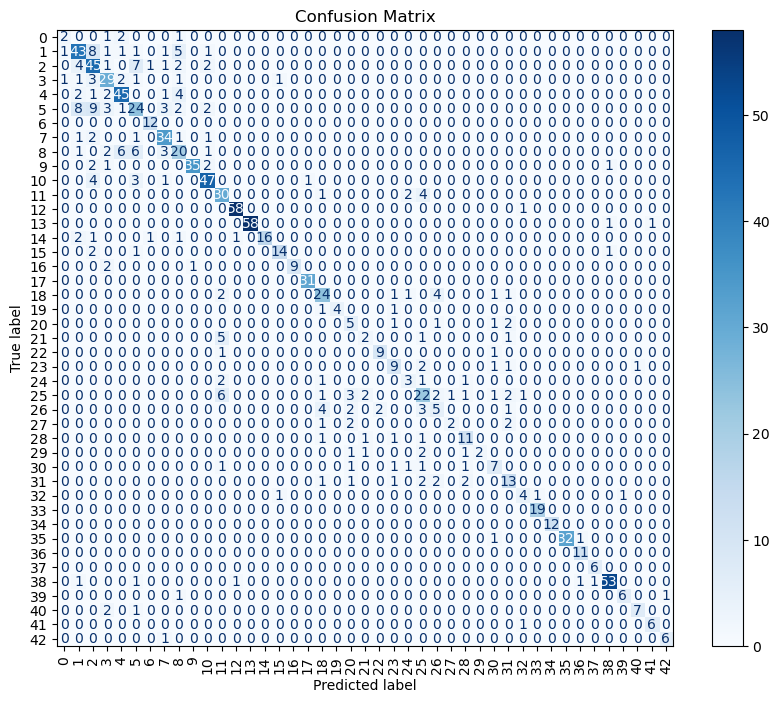

Top 20 Most Confident Predictions:
  id           image_path  predicted  truth  confidence  correct
3124 train/img_005083.jpg         15     15         1.0     True
3554 train/img_003103.jpg          1      1         1.0     True
3964 train/img_004051.jpg         40     40         1.0     True
6562 train/img_001746.jpg          7      7         1.0     True
5761 train/img_003301.jpg         12     12         1.0     True
5116 train/img_001151.jpg         10     10         1.0     True
6668 train/img_003277.jpg          3      3         1.0     True
4852 train/img_000570.jpg         33     33         1.0     True
5820 train/img_000635.jpg         37     37         1.0     True
7644 train/img_000986.jpg         35     35         1.0     True
5806 train/img_001961.jpg         11     11         1.0     True
1476 train/img_000734.jpg         17     17         1.0     True
4413 train/img_001750.jpg         38     38         1.0     True
4353 train/img_001345.jpg         12     12         1.0

In [7]:
knn_model = knn_final_pipeline.fit(extract_features_df(X_train), y_train)
X_test_features = extract_features_df(X_test)
knn_test_results = knn_model.predict(X_test_features)
knn_test_probs = knn_model.predict_proba(X_test_features)

evaluate_predictions(knn_test_results, y_test)
show_confidence_extremes(knn_test_probs, X_test, y_test)

Classification Report:

              precision    recall  f1-score   support

           0       0.50      0.33      0.40         6
           1       0.68      0.69      0.69        62
           2       0.58      0.71      0.64        63
           3       0.66      0.74      0.70        39
           4       0.79      0.82      0.80        55
           5       0.52      0.46      0.49        52
           6       0.86      1.00      0.92        12
           7       0.76      0.85      0.80        40
           8       0.53      0.51      0.52        39
           9       0.97      0.85      0.91        41
          10       0.84      0.84      0.84        56
          11       0.64      0.81      0.71        37
          12       0.97      0.98      0.97        59
          13       1.00      0.97      0.98        60
          14       1.00      0.73      0.84        22
          15       0.88      0.78      0.82        18
          16       1.00      0.75      0.86        12
   

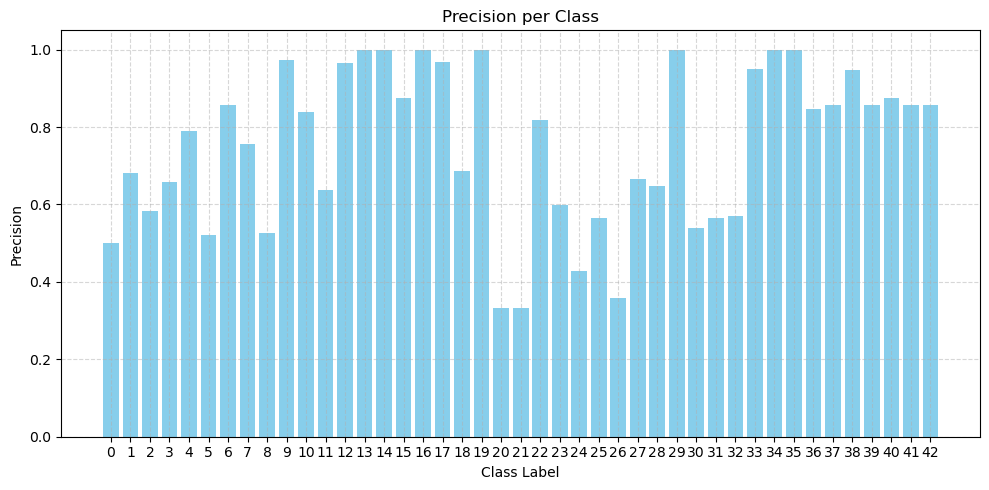

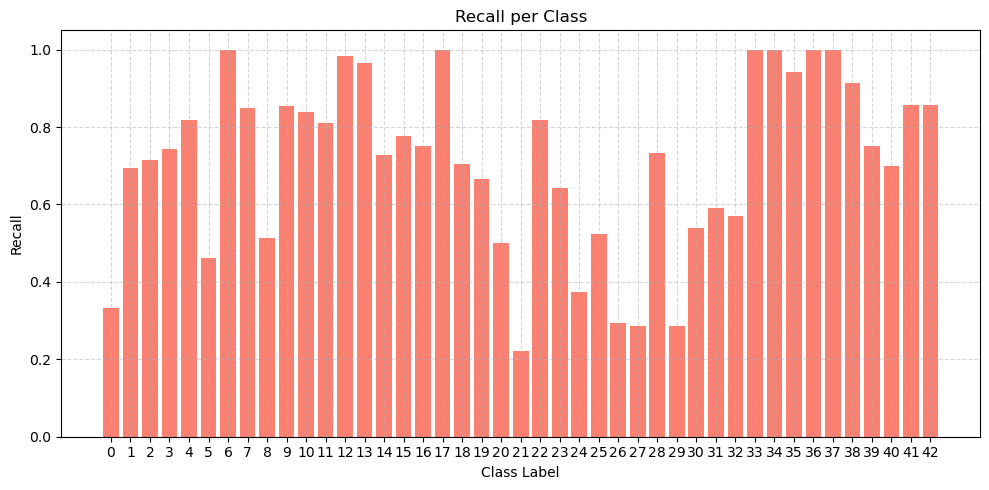

In [ ]:
print_report(knn_test_results, y_test)
plot_precision(knn_test_results, y_test)
plot_recall(knn_test_results, y_test)

Performance evaluation for Random Forest.

Accuracy: 0.9435


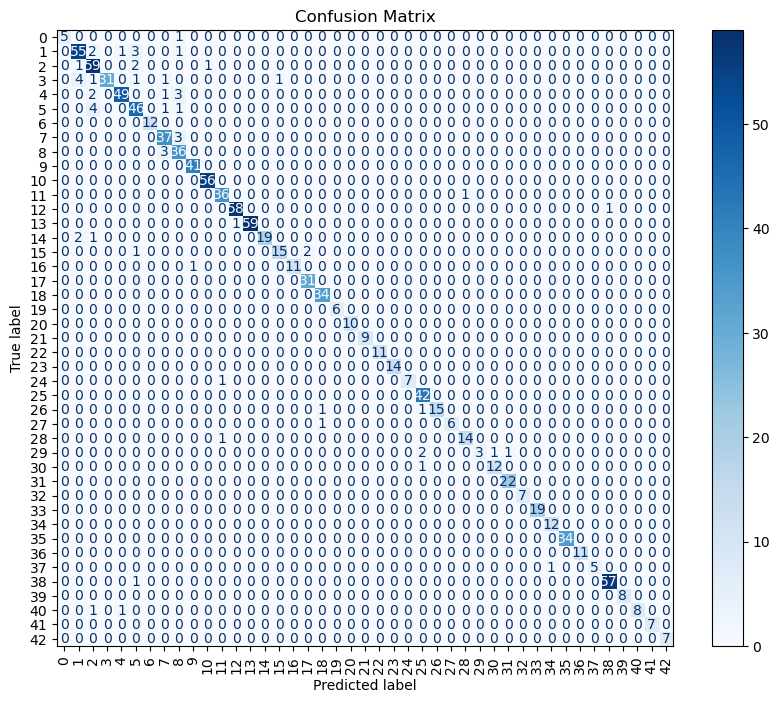

Top 20 Most Confident Predictions:
  id           image_path  predicted  truth  confidence  correct
5344 train/img_002790.jpg         17     17       1.000     True
1020 train/img_003110.jpg         13     13       1.000     True
7117 train/img_004204.jpg         17     17       1.000     True
5838 train/img_004041.jpg         17     17       1.000     True
7609 train/img_003582.jpg         13     13       1.000     True
1476 train/img_000734.jpg         17     17       1.000     True
 629 train/img_003930.jpg         13     13       1.000     True
1657 train/img_003445.jpg         13     13       1.000     True
4090 train/img_004780.jpg         13     13       1.000     True
6999 train/img_000603.jpg         17     17       1.000     True
2404 train/img_001777.jpg         13     13       1.000     True
4400 train/img_001701.jpg         17     17       1.000     True
4334 train/img_001915.jpg         13     13       1.000     True
4175 train/img_000965.jpg         13     13       0.995

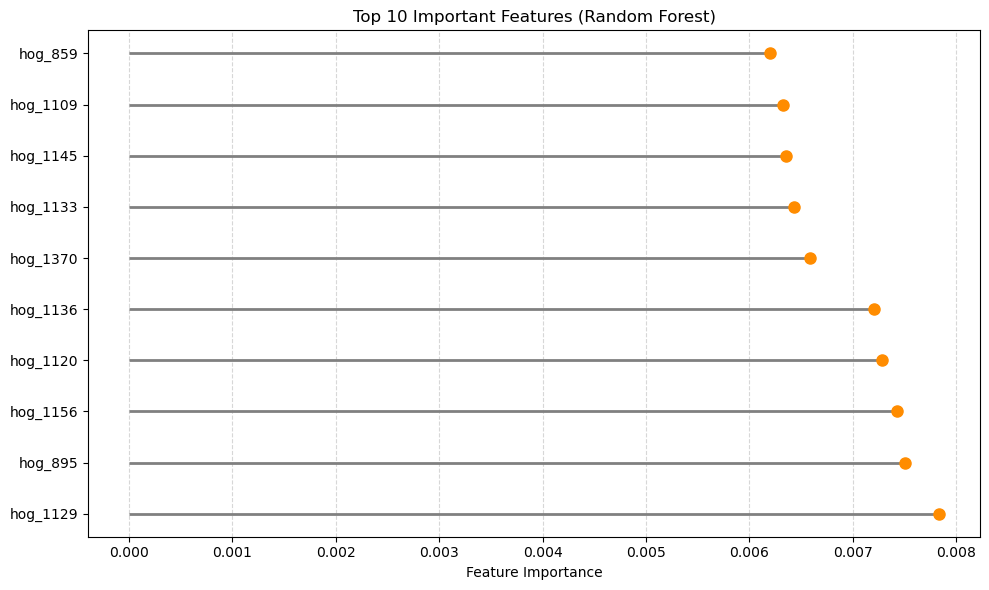

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def plot_top_rf_features_lollipop(importances, feature_names, top_n=20):
    """
    Plot feature importance using lollipop chart.
    """

    # extract top features and their importance index
    indices = np.argsort(importances)[::-1][:top_n]
    top_importances = importances[indices][::-1]
    top_features = [feature_names[i] for i in indices][::-1]

    # plot lollipop chart
    plt.figure(figsize=(10, 6))
    y_pos = np.arange(top_n)
    plt.hlines(y=y_pos, xmin=0, xmax=top_importances, color='gray', linewidth=2)
    plt.plot(top_importances, y_pos, 'o', markersize=8, color='darkorange')
    plt.yticks(y_pos, top_features)
    plt.xlabel("Feature Importance")
    plt.title(f"Top {top_n} Important Features (Random Forest)")
    plt.gca().invert_yaxis()
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


def plot_pipeline_feature_importances(pipeline, original_feature_names, top_n=10):
    """
    Plot top 10 features based on Random Forest's feature importance index.
    """

    rf = pipeline.named_steps.get('rf')

    # retreive features selected by mutual information scores
    selector = pipeline.named_steps['mi_select']
    mask = selector.get_support()
    reduced_feature_names = [f for f, keep in zip(original_feature_names, mask) if keep]
    importances = rf.feature_importances_

    # plot the features based on importance index
    plot_top_rf_features_lollipop(importances, reduced_feature_names, top_n)


rf_model = rf_final_pipeline.fit(extract_features_df(X_train), y_train)
X_test_features = extract_features_df(X_test)
rf_test_results = rf_model.predict(X_test_features)
rf_test_probs = rf_model.predict_proba(X_test_features)

evaluate_predictions(rf_test_results, y_test)
show_confidence_extremes(rf_test_probs, X_test, y_test)
plot_pipeline_feature_importances(rf_model, original_feature_names=X_test_features.columns, top_n=10)

Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.83      0.91         6
           1       0.89      0.89      0.89        62
           2       0.84      0.94      0.89        63
           3       1.00      0.79      0.89        39
           4       0.96      0.89      0.92        55
           5       0.85      0.88      0.87        52
           6       1.00      1.00      1.00        12
           7       0.86      0.93      0.89        40
           8       0.80      0.92      0.86        39
           9       0.98      1.00      0.99        41
          10       0.98      1.00      0.99        56
          11       0.95      0.97      0.96        37
          12       0.98      0.98      0.98        59
          13       1.00      0.98      0.99        60
          14       1.00      0.86      0.93        22
          15       0.94      0.83      0.88        18
          16       1.00      0.92      0.96        12
   

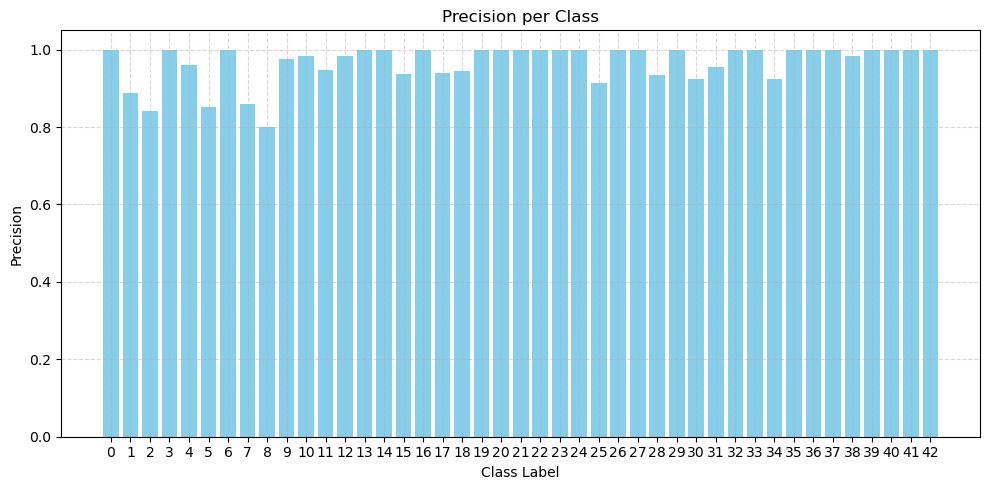

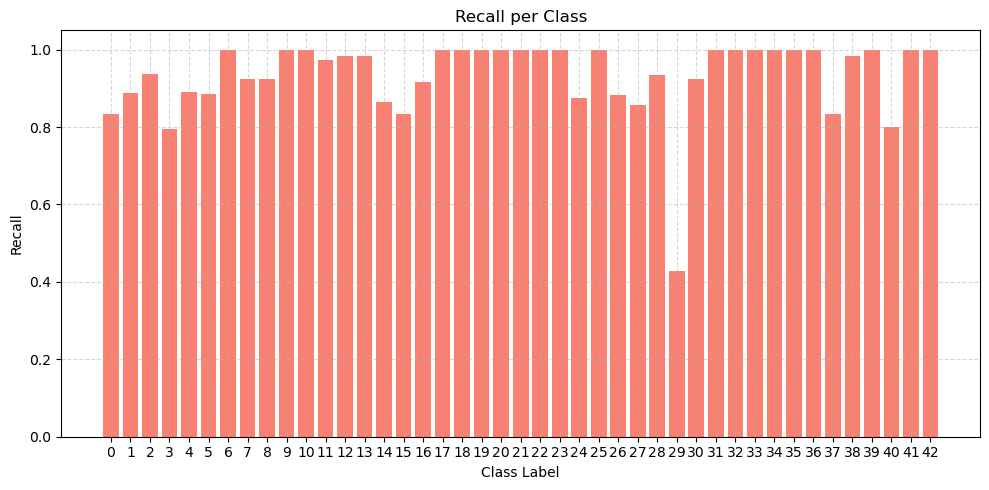

In [ ]:
print_report(rf_test_results, y_test)
plot_precision(rf_test_results, y_test)
plot_recall(rf_test_results, y_test)

Performance evaluation for CNN.

In [8]:
# cnn_model = train_cnn_model(X_train, epochs=35)

# save model weights
# torch.save(cnn_model.state_dict(), 'cnn_eval_state.pt')

# load model weights
cnn_model = build_cnn()
cnn_model.load_state_dict(torch.load('cnn_eval_state.pt'))

<All keys matched successfully>

Accuracy: 0.9654


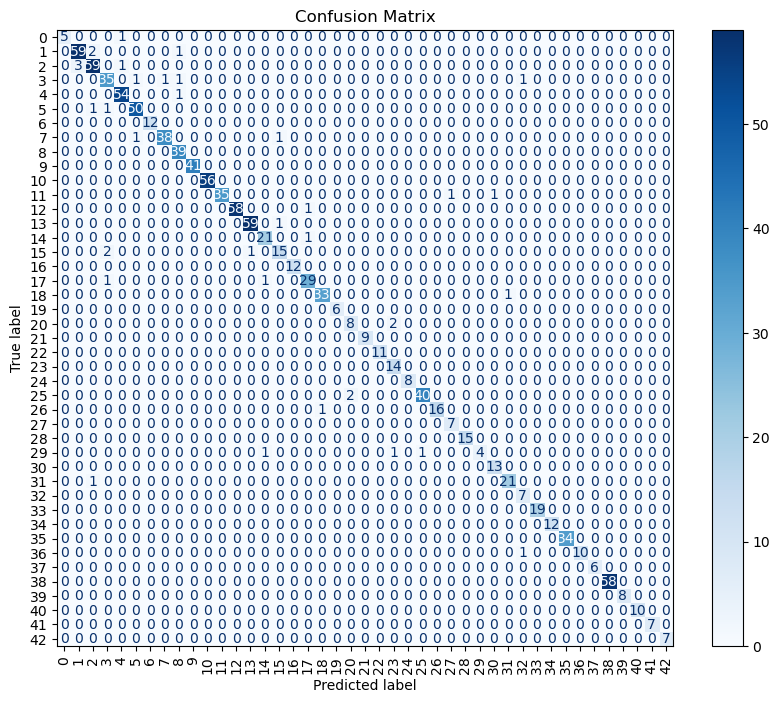

Top 20 Most Confident Predictions:
  id           image_path  predicted  truth  confidence  correct
5196 train/img_002979.jpg         12     12    0.999965     True
5310 train/img_005025.jpg         12     12    0.999965     True
3998 train/img_001016.jpg         12     12    0.999964     True
6119 train/img_001277.jpg         12     12    0.999957     True
5936 train/img_001215.jpg         12     12    0.999956     True
7624 train/img_005309.jpg         12     12    0.999951     True
1314 train/img_001400.jpg         12     12    0.999946     True
5380 train/img_002273.jpg         12     12    0.999943     True
 230 train/img_004988.jpg         12     12    0.999942     True
7783 train/img_002138.jpg         12     12    0.999941     True
4269 train/img_003781.jpg         12     12    0.999939     True
5664 train/img_004328.jpg         12     12    0.999929     True
 265 train/img_002956.jpg         12     12    0.999928     True
4721 train/img_002188.jpg         12     12    0.999928

In [10]:
MEAN_RGB = [0.3434230387210846, 0.3145091235637665, 0.32351312041282654]
STD_RGB = [0.16245444118976593, 0.1610783040523529, 0.1703355610370636]

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

def cnn_predict_proba(model, df, batch_size=64):
    """
    Extract confidence values (softmax) for each prediction for CNN.
    """
    device = torch.device('cpu')
    model.eval()
    transform = get_transforms()

    # load dataset
    dataset = ImageDataset(df, transform)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    all_probs = []

    with torch.no_grad():
        for images in loader:
            images = images.to(device)
            logits = model(images)
            
            # convert logits to softmax values with softmax function
            probs = F.softmax(logits, dim=1)
            all_probs.extend(probs.cpu().numpy())

    return all_probs


cnn_test_results = cnn_predict(cnn_model, X_test)
cnn_test_probs = cnn_predict_proba(cnn_model, X_test)
evaluate_predictions(cnn_test_results, y_test)
show_confidence_extremes(cnn_test_probs, X_test, y_test)


Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.83      0.91         6
           1       0.95      0.95      0.95        62
           2       0.94      0.94      0.94        63
           3       0.90      0.90      0.90        39
           4       0.96      0.98      0.97        55
           5       0.96      0.96      0.96        52
           6       1.00      1.00      1.00        12
           7       0.97      0.95      0.96        40
           8       0.93      1.00      0.96        39
           9       1.00      1.00      1.00        41
          10       1.00      1.00      1.00        56
          11       1.00      0.95      0.97        37
          12       1.00      0.98      0.99        59
          13       0.98      0.98      0.98        60
          14       0.91      0.95      0.93        22
          15       0.88      0.83      0.86        18
          16       1.00      1.00      1.00        12
   

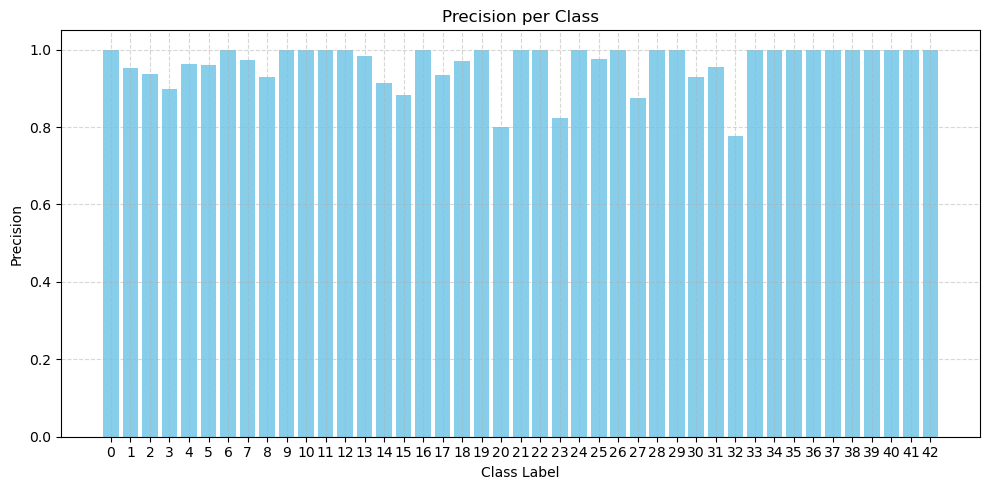

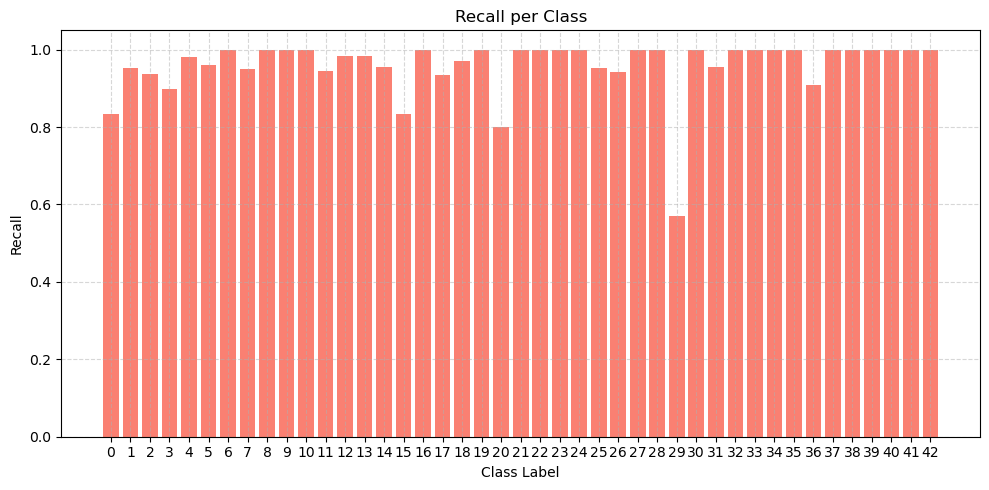

In [16]:
print_report(cnn_test_results, y_test)
plot_precision(cnn_test_results, y_test)
plot_recall(cnn_test_results, y_test)

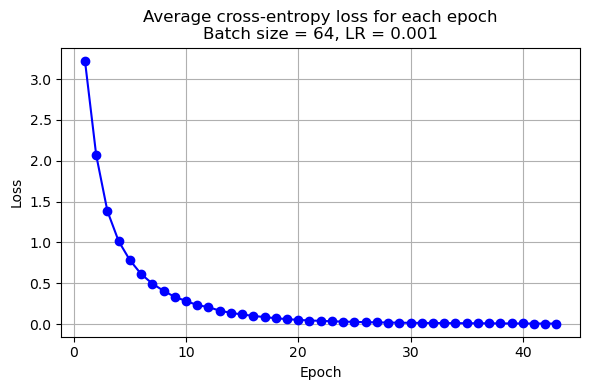

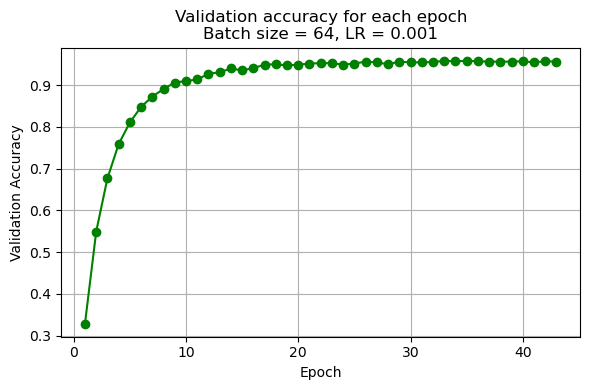

In [17]:
import matplotlib.pyplot as plt
import re

def plot_val_accuracy_from_log_file(file_path):
    """
    Plot model tuning validation score for each epoch.
    """
    with open(file_path, 'r') as f:
        lines = f.readlines()

    title = "Validation accuracy for each epoch\nBatch size = 64, LR = 0.001"

    # extract accuracies for each epoch
    epoch_nums = []
    val_accuracies = []
    for line in lines[1:]:
        match = re.search(r"Epoch\s+(\d+):\s+Loss\s+=\s+[\d.]+,\s+Val Acc\s+=\s+([\d.]+)", line)
        if match:
            epoch_nums.append(int(match.group(1)))
            val_accuracies.append(float(match.group(2)))

    # plot line graph
    plt.figure(figsize=(6, 4))
    plt.plot(epoch_nums, val_accuracies, marker='o', color='green')
    plt.xlabel("Epoch")
    plt.ylabel("Validation Accuracy")
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_loss_from_log_file(file_path):
    """
    Plot model tuning average cross-entropy loss for each epoch.
    """
    with open(file_path, 'r') as f:
        lines = f.readlines()

    title = "Average cross-entropy loss for each epoch\nBatch size = 64, LR = 0.001"

    # extract average cross-entropy loss for each epoch
    epoch_nums = []
    losses = []
    for line in lines[1:]:
        match = re.search(r"Epoch\s+(\d+):\s+Loss\s+=\s+([\d.]+)", line)
        if match:
            epoch_nums.append(int(match.group(1)))
            losses.append(float(match.group(2)))

    # plot line graph
    plt.figure(figsize=(6, 4))
    plt.plot(epoch_nums, losses, marker='o', color='blue')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_loss_from_log_file("tuned_hyperparameters.txt")
plot_val_accuracy_from_log_file("tuned_hyperparameters.txt")

Error analysis for KNN.

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.stats import percentileofscore

def show_comparison(prediction_probs, ground_truth, test_df, actual, pred):
    """
    Compare wrongly misclassified image with the predicted class image. Also compute
    the confidence value with the percentile for the confidence value.
    """
    prediction_probs = np.array(prediction_probs)
    ground_truth = np.array(ground_truth)
    predicted_labels = np.argmax(prediction_probs, axis=1)

    # misclssified image's confidence
    mis_mask = (ground_truth == actual) & (predicted_labels == pred)
    mis_indices = np.where(mis_mask)[0]
    mis_confidences = prediction_probs[mis_indices, pred]
    mis_idx = mis_indices[np.argmin(mis_confidences)]
    mis_conf = prediction_probs[mis_idx, pred]
    mis_path = test_df.iloc[mis_idx]['image_path']

    # get confidence of all predictions for their predicted label
    all_predicted_confidences = prediction_probs[np.arange(len(prediction_probs)), predicted_labels]

    # misclassified image's confidence value percentile
    mis_percentile = percentileofscore(all_predicted_confidences, mis_conf, kind='rank')

    # correctly predicted image's confidence
    correct_mask = (ground_truth == pred) & (predicted_labels == pred)
    correct_indices = np.where(correct_mask)[0]
    correct_confidences = prediction_probs[correct_indices, pred]
    correct_idx = correct_indices[np.argmax(correct_confidences)]
    correct_conf = prediction_probs[correct_idx, pred]
    correct_path = test_df.iloc[correct_idx]['image_path']

    # correctly predicted image's confidence percentile
    correct_percentile = percentileofscore(all_predicted_confidences, correct_conf, kind='rank')

    # load and show images
    mis_image = Image.open(mis_path)
    correct_image = Image.open(correct_path)

    _, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].imshow(mis_image)
    axes[0].set_title(f"Misclassified\nTrue: {actual}, Pred: {pred}")
    axes[0].axis('off')

    axes[1].imshow(correct_image)
    axes[1].set_title(f"Correct Prediction\nTrue & Pred: {pred}")
    axes[1].axis('off')
    plt.tight_layout()
    plt.show()

    # print details regarding confidence values
    print("Misclassified Example")
    print(f"Image path: {mis_path}")
    print(f"Confidence for predicted class ({pred}): {mis_conf:.4f}")
    print(f"Percentile of confidence in all predictions: {mis_percentile:.2f}%\n")

    print("Correct Prediction Example")
    print(f"Image path: {correct_path}")
    print(f"Confidence for predicted class ({pred}): {correct_conf:.4f}")
    print(f"Percentile of confidence in all predictions: {correct_percentile:.2f}%")


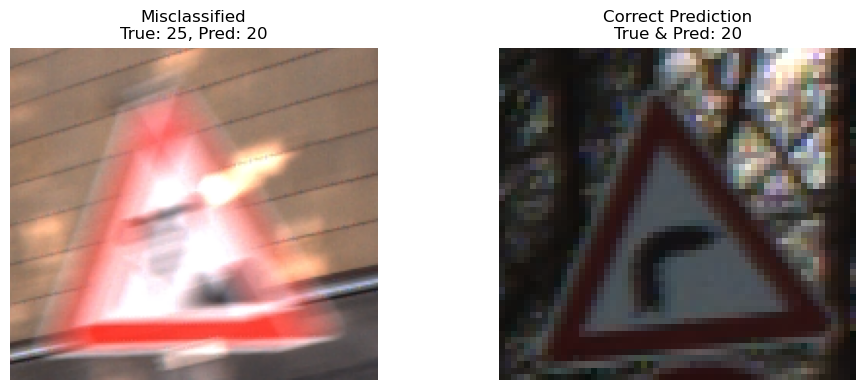

Misclassified Example
Image path: train/img_004456.jpg
Confidence for predicted class (20): 0.2067
Percentile of confidence in all predictions: 0.09%

Correct Prediction Example
Image path: train/img_001577.jpg
Confidence for predicted class (20): 0.7286
Percentile of confidence in all predictions: 41.17%


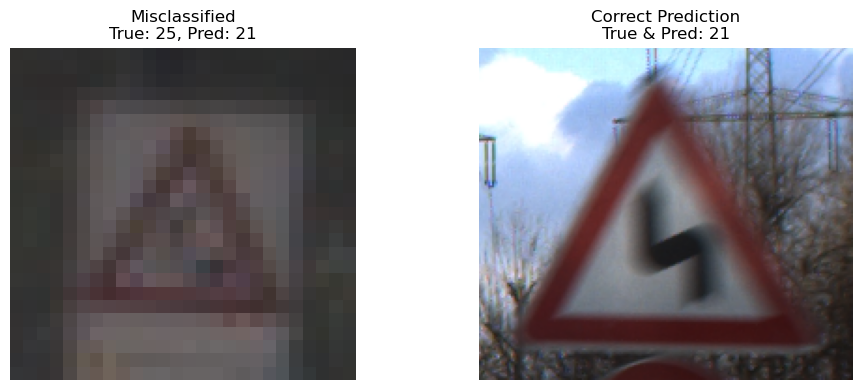

Misclassified Example
Image path: train/img_004442.jpg
Confidence for predicted class (21): 0.2609
Percentile of confidence in all predictions: 2.46%

Correct Prediction Example
Image path: train/img_004693.jpg
Confidence for predicted class (21): 0.5901
Percentile of confidence in all predictions: 24.68%


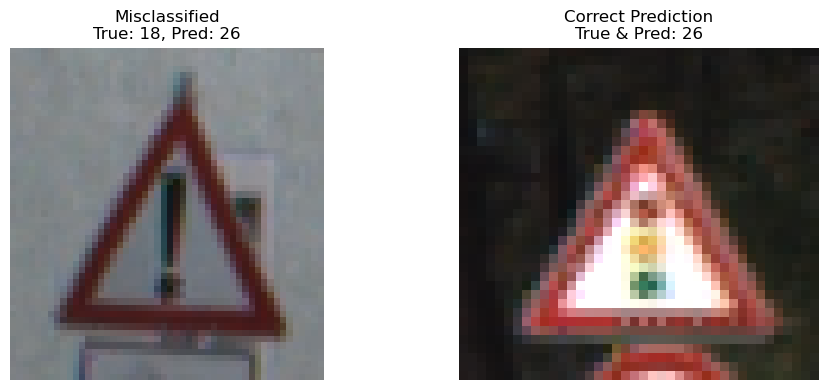

Misclassified Example
Image path: train/img_002400.jpg
Confidence for predicted class (26): 0.4067
Percentile of confidence in all predictions: 9.47%

Correct Prediction Example
Image path: train/img_000714.jpg
Confidence for predicted class (26): 0.8413
Percentile of confidence in all predictions: 55.10%


In [19]:
show_comparison(knn_test_probs, y_test, X_test, 25, 20)
show_comparison(knn_test_probs, y_test, X_test, 25, 21)
show_comparison(knn_test_probs, y_test, X_test, 18, 26)

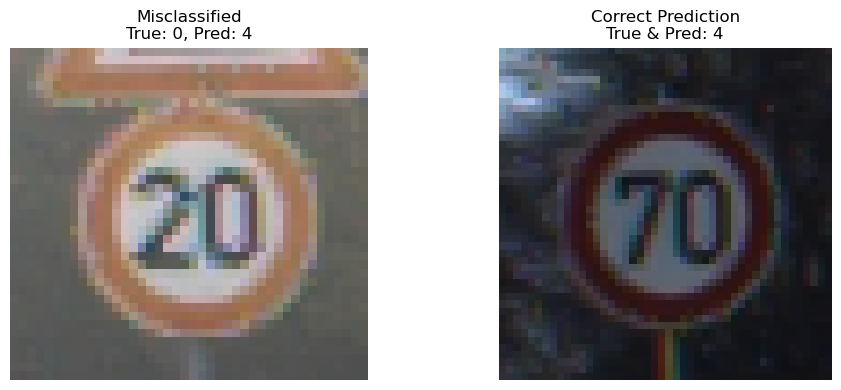

Misclassified Example
Image path: train/img_003040.jpg
Confidence for predicted class (4): 0.5989
Percentile of confidence in all predictions: 27.50%

Correct Prediction Example
Image path: train/img_002534.jpg
Confidence for predicted class (4): 1.0000
Percentile of confidence in all predictions: 78.23%


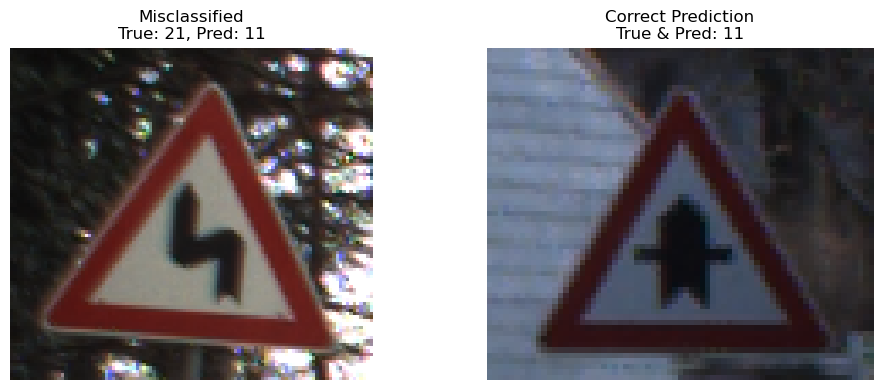

Misclassified Example
Image path: train/img_000703.jpg
Confidence for predicted class (11): 0.4142
Percentile of confidence in all predictions: 12.30%

Correct Prediction Example
Image path: train/img_005248.jpg
Confidence for predicted class (11): 1.0000
Percentile of confidence in all predictions: 78.23%


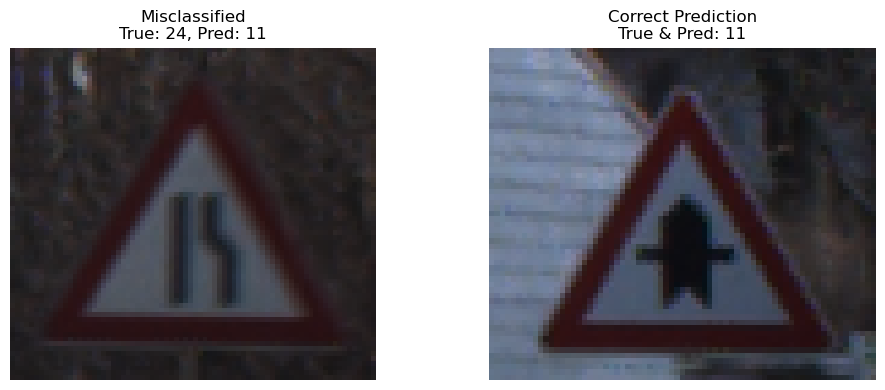

Misclassified Example
Image path: train/img_004057.jpg
Confidence for predicted class (11): 0.4177
Percentile of confidence in all predictions: 13.02%

Correct Prediction Example
Image path: train/img_005248.jpg
Confidence for predicted class (11): 1.0000
Percentile of confidence in all predictions: 78.23%


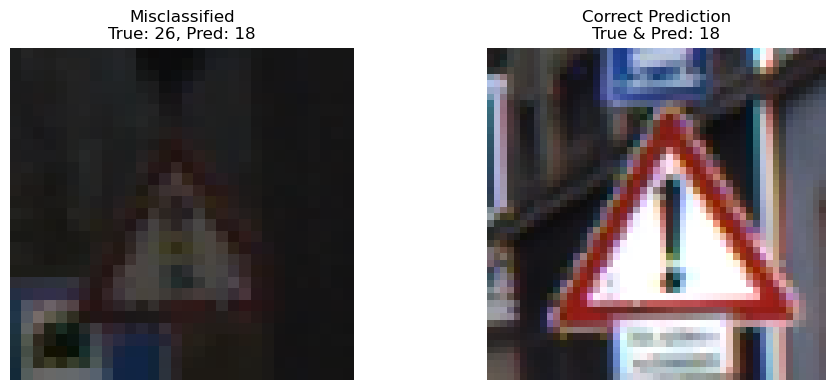

Misclassified Example
Image path: train/img_003218.jpg
Confidence for predicted class (18): 0.3753
Percentile of confidence in all predictions: 3.92%

Correct Prediction Example
Image path: train/img_004314.jpg
Confidence for predicted class (18): 1.0000
Percentile of confidence in all predictions: 78.23%


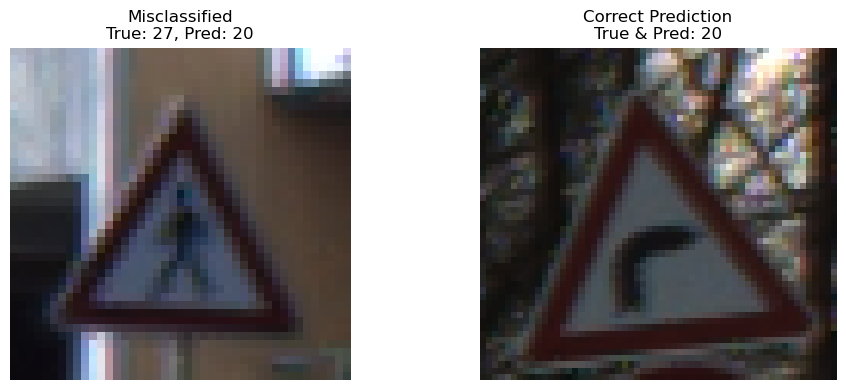

Misclassified Example
Image path: train/img_001271.jpg
Confidence for predicted class (20): 0.3801
Percentile of confidence in all predictions: 4.19%

Correct Prediction Example
Image path: train/img_001577.jpg
Confidence for predicted class (20): 0.7286
Percentile of confidence in all predictions: 41.17%


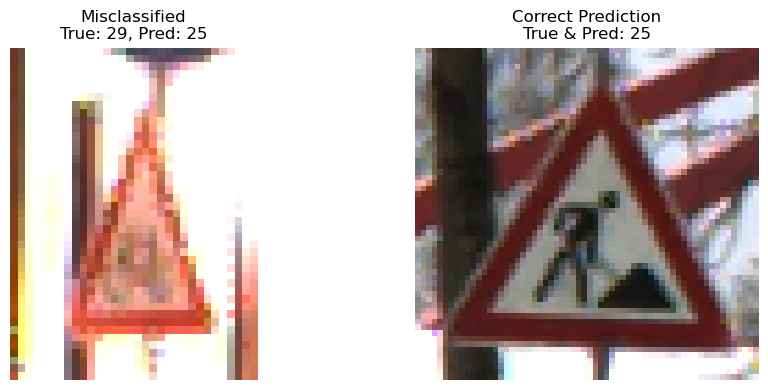

Misclassified Example
Image path: train/img_002169.jpg
Confidence for predicted class (25): 0.4082
Percentile of confidence in all predictions: 10.20%

Correct Prediction Example
Image path: train/img_003713.jpg
Confidence for predicted class (25): 1.0000
Percentile of confidence in all predictions: 78.23%


In [20]:
show_comparison(knn_test_probs, y_test, X_test, 0, 4)
show_comparison(knn_test_probs, y_test, X_test, 21, 11)
show_comparison(knn_test_probs, y_test, X_test, 24, 11)
show_comparison(knn_test_probs, y_test, X_test, 26, 18)
show_comparison(knn_test_probs, y_test, X_test, 27, 20)
show_comparison(knn_test_probs, y_test, X_test, 29, 25)


Error analysis for Random Forest, CNN.

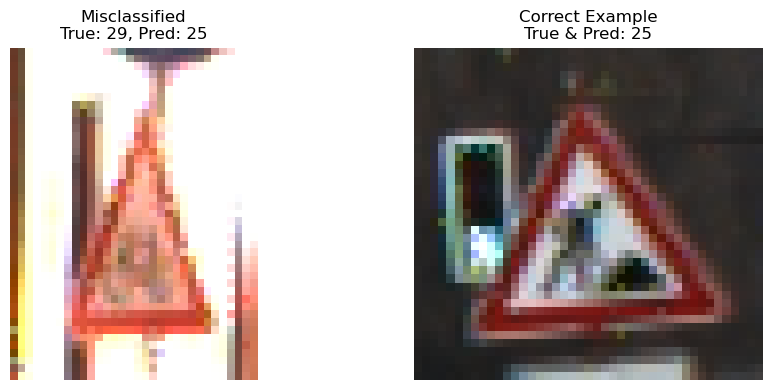

[1] Misclassified Example
Image path: train/img_002169.jpg
Confidence for predicted class (25): 0.1000
Percentile of confidence in all predictions: 0.27%



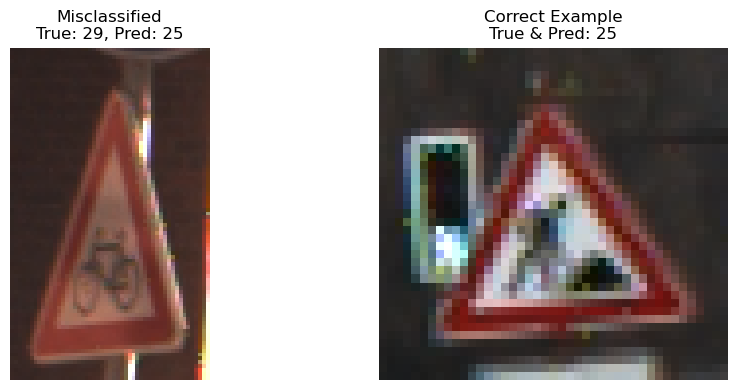

[2] Misclassified Example
Image path: train/img_003587.jpg
Confidence for predicted class (25): 0.1700
Percentile of confidence in all predictions: 2.23%

Reference Correct Prediction
Image path: train/img_000620.jpg
Confidence for predicted class (25): 0.8700
Percentile of confidence in all predictions: 78.83%


In [21]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.stats import percentileofscore

def show_all_misclassifications(prediction_probs, ground_truth, test_df, actual, pred, max_display=5):
    """
    Display a specified number of misclassifications for certain classes.
    """
    prediction_probs = np.array(prediction_probs)
    ground_truth = np.array(ground_truth)
    predicted_labels = np.argmax(prediction_probs, axis=1)

    # get all specified misclassifications
    mis_mask = (ground_truth == actual) & (predicted_labels == pred)
    mis_indices = np.where(mis_mask)[0]
    all_predicted_confidences = prediction_probs[np.arange(len(prediction_probs)), predicted_labels]

    # extract confidence value for correct predictions
    correct_mask = (ground_truth == pred) & (predicted_labels == pred)
    correct_indices = np.where(correct_mask)[0]
    correct_confidences = prediction_probs[correct_indices, pred]
    best_correct_idx = correct_indices[np.argmax(correct_confidences)]
    best_correct_path = test_df.iloc[best_correct_idx]['image_path']
    best_correct_conf = prediction_probs[best_correct_idx, pred]
    best_correct_percentile = percentileofscore(all_predicted_confidences, best_correct_conf, kind='rank')

    # load an example of correctly classified image
    best_correct_image = Image.open(best_correct_path)

    # display all misclassified images (up to max_display)
    for i, mis_idx in enumerate(mis_indices[:max_display]):
        # calculate confidence value for misclassified instances
        mis_path = test_df.iloc[mis_idx]['image_path']
        mis_conf = prediction_probs[mis_idx, pred]
        mis_percentile = percentileofscore(all_predicted_confidences, mis_conf, kind='rank')
        mis_image = Image.open(mis_path)

        # show both misclassified and correct example
        _, axes = plt.subplots(1, 2, figsize=(10, 4))
        axes[0].imshow(mis_image)
        axes[0].set_title(f"Misclassified\nTrue: {actual}, Pred: {pred}")
        axes[0].axis('off')

        axes[1].imshow(best_correct_image)
        axes[1].set_title(f"Correct Example\nTrue & Pred: {pred}")
        axes[1].axis('off')

        plt.tight_layout()
        plt.show()

        # show details regarding confidence values
        print(f"[{i+1}] Misclassified Example")
        print(f"Image path: {mis_path}")
        print(f"Confidence for predicted class ({pred}): {mis_conf:.4f}")
        print(f"Percentile of confidence in all predictions: {mis_percentile:.2f}%\n")

    print("Reference Correct Prediction")
    print(f"Image path: {best_correct_path}")
    print(f"Confidence for predicted class ({pred}): {best_correct_conf:.4f}")
    print(f"Percentile of confidence in all predictions: {best_correct_percentile:.2f}%")


show_all_misclassifications(rf_test_probs, y_test, X_test, 29, 25)


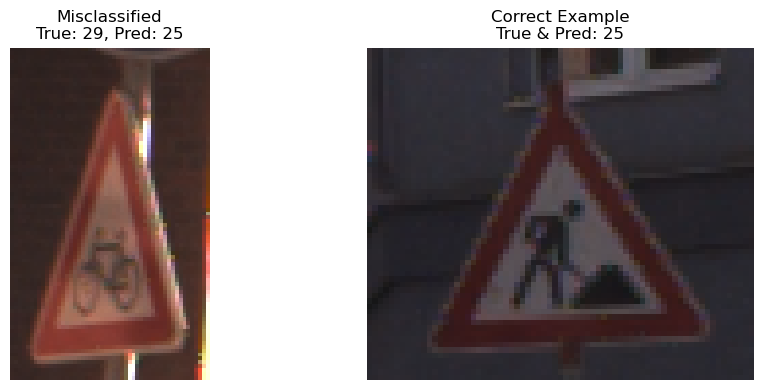

[1] Misclassified Example
Image path: train/img_003587.jpg
Confidence for predicted class (25): 0.4407
Percentile of confidence in all predictions: 1.09%

Reference Correct Prediction
Image path: train/img_003858.jpg
Confidence for predicted class (25): 0.9999
Percentile of confidence in all predictions: 97.81%


In [22]:
show_all_misclassifications(cnn_test_probs, y_test, X_test, 29, 25)

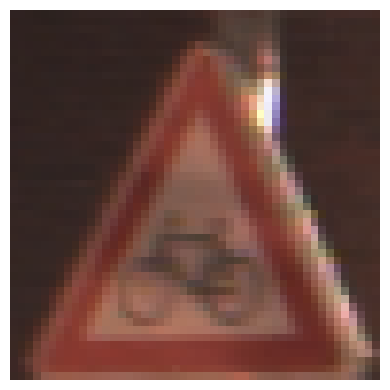

Random Forest prediction: [29]
Prediction confidence: 0.115
CNN prediction: [25]
Prediction confidence: 0.35057625


In [11]:
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt

def show_perspective_transformed(image_path):
    """
    Apply a perspective transformation by simulating a different viewpoint
    for the misclassified signs.
    """

    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w = image.shape[:2]

    # source points (simulate angled view)
    src = np.float32([
        [w * 0.05, h * 0.05],
        [w * 0.95, h * 0.05],
        [w * 0.9, h * 0.9],
        [w * 0.05, h * 0.95]
    ])

    # destination rectangle
    dst_height, dst_width = 48, 48
    dst = np.float32([
        [0, 0],
        [dst_width, 0],
        [dst_width, dst_height],
        [0, dst_height]
    ])

    # perspective transformation
    matrix = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(image_rgb, matrix, (dst_width, dst_height))

    # plot the new image
    plt.figure(figsize=(4, 4))
    plt.imshow(warped)
    plt.axis('off')
    plt.tight_layout()
    plt.show()


# apply transformation to the misclassified image with tilted camera angle
show_perspective_transformed("train/img_003587.jpg")

new_test = pd.DataFrame({
    "image_path": ["perspective_transformed.png"]
})

# get predictions from both models for the transformed image
rf_new_prediction = rf_model.predict_proba(extract_features_df(new_test))
print("Random Forest prediction:", rf_model.predict(extract_features_df(new_test)))
print("Prediction confidence:", rf_new_prediction[0][29])

cnn_new_prediction = cnn_predict_proba(cnn_model, new_test)
print("CNN prediction:", cnn_predict(cnn_model, new_test))
print("Prediction confidence:", cnn_new_prediction[0][25])


## 4. Produce Kaggle Test Results

In [24]:
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import KBinsDiscretizer

# load training data
metadata = pd.read_csv("train/train_metadata.csv")
metadata['image_path'] = 'train/' + metadata['image_path'].astype(str)

# load test data
test_metadata = pd.read_csv("test/test_metadata.csv")
test_metadata['image_path'] = 'test/' + test_metadata['image_path'].astype(str)
ids = test_metadata["id"]

class QuantileDiscretizer(BaseEstimator, TransformerMixin):
    def __init__(self, n_bins=10):
        self.n_bins = n_bins
        self.discretizer = None

    def fit(self, X, y=None):
        self.discretizer = KBinsDiscretizer(n_bins=self.n_bins, encode='ordinal', strategy='uniform')
        self.discretizer.fit(X)
        return self

    def transform(self, X):
        return self.discretizer.transform(X)


In [25]:
# train KNN model
knn_final = Pipeline([
    ('discretizer', QuantileDiscretizer(n_bins=43)),
    ('mi_select', SelectKBest(lambda X, y: mutual_info_classif(X, y, discrete_features=True), k=50)),
    ('scaler', MinMaxScaler()),
    ('pca', PCA(n_components=0.9, svd_solver='full')),
    ('knn', KNeighborsClassifier(n_neighbors=5, weights='distance', n_jobs=-1))
])
knn_final.fit(extract_features_df(metadata), metadata['ClassId'])

# get Kaggle test predictions
knn_kaggle = knn_final.predict(extract_features_df(test_metadata))
knn_csv = pd.concat([ids, pd.Series(knn_kaggle, name="ClassId")], axis=1)
knn_csv.to_csv('knn_pred.csv', index=False)

In [26]:
# train Random Forest model
rf_final = Pipeline([
    ('discretizer', QuantileDiscretizer(n_bins=43)),
    ('mi_select', SelectKBest(lambda X, y: mutual_info_classif(X, y, discrete_features=True), k=300)),
    ('rf', RandomForestClassifier(n_estimators=200,
                                  max_features=9,
                                  class_weight='balanced',
                                  n_jobs=-1, 
                                  random_state=123))
])
rf_final.fit(extract_features_df(metadata), metadata['ClassId'])

# get Kaggle test predictions
rf_kaggle = rf_final.predict(extract_features_df(test_metadata))
rf_csv = pd.concat([ids, pd.Series(rf_kaggle, name="ClassId")], axis=1)
rf_csv.to_csv('random_forest_pred.csv', index=False)

In [27]:
# train cnn model
# cnn_final = train_cnn_model(metadata, epochs=35)

# save cnn model weights
# torch.save(cnn_final.state_dict(), 'cnn_kaggle_state.pt')

In [62]:
# mean and std of RGB for training set
MEAN_RGB = [0.3434169292449951, 0.3141884207725525, 0.322788804769516]
STD_RGB = [0.16258008778095245, 0.16106145083904266, 0.16989701986312866]

# load cnn model weights
cnn_final = build_cnn()
cnn_final.load_state_dict(torch.load('cnn_kaggle_state.pt'))

# get Kaggle test predictions
cnn_kaggle = cnn_predict(cnn_final, test_metadata)
cnn_csv = pd.concat([ids, pd.Series(cnn_kaggle, name="ClassId")], axis=1)
cnn_csv.to_csv('cnn_pred.csv', index=False)
